<a href="https://colab.research.google.com/github/PSKdream/CE59423/blob/main/project/banana_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

!pip install roboflow
from roboflow import Roboflow

     |████████████████████████████████| 145 kB 7.1 MB/s 
     |████████████████████████████████| 178 kB 56.1 MB/s 
     |████████████████████████████████| 1.1 MB 78.7 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 138 kB 104.2 MB/s 
     |████████████████████████████████| 596 kB 64.6 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for roboflow: filename=roboflow-0.2.4-py3-none-any.whl size=21356 sha256=f70dffdba58abac0cb94e9d1cd99c40a42d950c6dba33c6c127c1f1509bb7f08
  Stored in directory: /root/.cache/pip/wheels/b7/2c/60/3733c0e323b1d7aec00f852264314bf6c48192c8e1dc92b3ee
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=f445730236c36aad49f923b062b041cf6535fee7a37eae8dedab02b830c1163c
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built roboflow wge

#preprocessing

In [ ]:
!gdown 1_AgNku-CYQFEIJlB7t9qUMRjrAXFJfgK

Downloading...
From: https://drive.google.com/uc?id=1_AgNku-CYQFEIJlB7t9qUMRjrAXFJfgK
To: /content/_annotation.csv
100% 1.26k/1.26k [00:00<00:00, 2.62MB/s]


In [ ]:
rf = Roboflow(api_key="Zp2LHMrGIeq024hrszRm")
project = rf.workspace("new-workspace-uypfa").project("banana-gk4h0")
dataset = project.version(1).download("tensorflow")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to banana-1 in tensorflow:: 100%|██████████| 896/896 [00:00<00:00, 2496.31it/s]


In [ ]:
annotation = pd.read_csv('./_annotation.csv')

In [ ]:
img_path = os.path.join(dataset.location,'train')
df = pd.DataFrame([], columns=['Filepath', 'Weight'])

for file in os.listdir(img_path):
  if file.endswith(".jpg"):
    filename = file.split('.')[0][:-4]+'.jpg'
    weight = annotation[annotation['img'].isin([filename])]['weight'].values[0]*1.0
    # print(filename, weight)
    temp = pd.DataFrame([[os.path.join(img_path,file), weight]], columns=['Filepath', 'Weight'])
    df = pd.concat([df, temp], ignore_index=True)

In [ ]:
train_df, test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
target_size = (256, 256) #(1748//4, 2480//4)#(128, 128) # (416,416)
batch_size = 128
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Weight',
    target_size= target_size, #(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Weight',
    target_size=target_size, #(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Weight',
    target_size=target_size, #(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=False
)

Found 500 validated image filenames.
Found 124 validated image filenames.
Found 268 validated image filenames.


#Model3

https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_2_cnn.ipynb

In [ ]:
inputs = tf.keras.Input(shape=target_size+(3,))
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same")(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = tf.keras.layers.MaxPool2D()(x)
# x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding="same")(x)
# x = tf.keras.layers.MaxPool2D()(x)
# x = tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding="same")(x)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        1846

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
4/4 [==============================] - 24s 6s/step - loss: 31.8794 - val_loss: 285.9697
Epoch 2/100
4/4 [==============================] - 18s 5s/step - loss: 30.0291 - val_loss: 288.2835
Epoch 3/100
4/4 [==============================] - 18s 5s/step - loss: 29.2853 - val_loss: 283.6703
Epoch 4/100
4/4 [==============================] - 18s 5s/step - loss: 31.2522 - val_loss: 278.2755
Epoch 5/100
4/4 [==============================] - 18s 5s/step - loss: 30.2843 - val_loss: 287.6939
Epoch 6/100
4/4 [==============================] - 20s 5s/step - loss: 25.1114 - val_loss: 290.0004
Epoch 7/100
4/4 [==============================] - 18s 5s/step - loss: 25.6692 - val_loss: 290.0291
Epoch 8/100
4/4 [==============================] - 18s 5s/step - loss: 24.9215 - val_loss: 276.3182
Epoch 9/100
4/4 [==============================] - 18s 5s/step - loss: 27.0579 - val_loss: 266.8919
Epoch 10/100
4/4 [==============================] - 18s 5s/step - loss: 23.4564 - val_loss: 272.9323

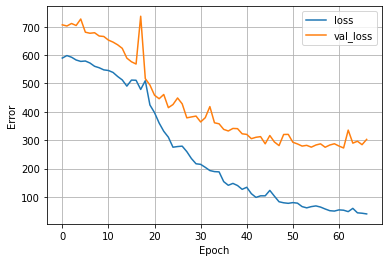

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
# plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

In [ ]:
predicted_weight = np.squeeze(model.predict(test_images))
true_ages = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("Test RMSE: {:.5f}".format(rmse))

mae = tf.keras.losses.mean_absolute_error(true_ages, predicted_weight)
mae = mae.numpy()
print("Test MAE: {:.5f}".format(mae))

r2 = r2_score(true_ages, predicted_weight)
print("Test R^2 Score: {:.5f}".format(r2))

Test RMSE: 15.63653
Test MAE: 9.70698
Test R^2 Score: 0.71063


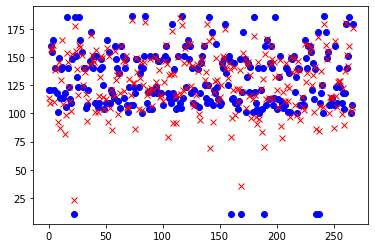

In [ ]:
plt.plot(true_ages, 'ob')
plt.plot(predicted_weight, 'xr')

##save model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
filename = './05052022_model3.keras'
model.save(filename)

In [ ]:
%cp {filename} ./drive/MyDrive/[ML]FinalProject/{filename}

#load model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
net = tf.keras.models.load_model('/content/drive/MyDrive/[ML]FinalProject/05052022_model3.keras')

In [ ]:
predicted_weight = np.squeeze(net.predict(test_images))
true_ages = test_images.labels

rmse = np.sqrt(net.evaluate(test_images, verbose=0))
print("Test RMSE: {:.5f}".format(rmse))

mae = tf.keras.losses.mean_absolute_error(true_ages, predicted_weight)
mae = mae.numpy()
print("Test MAE: {:.5f}".format(mae))

r2 = r2_score(true_ages, predicted_weight)
print("Test R^2 Score: {:.5f}".format(r2))

Test RMSE: 9.73830
Test MAE: 4.23024
Test R^2 Score: 0.88776


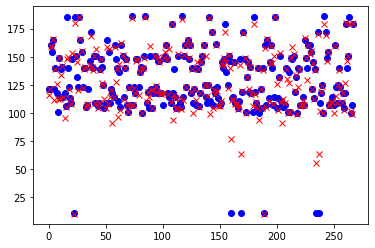

In [ ]:
plt.plot(true_ages, 'ob')
plt.plot(predicted_weight, 'xr')